# Classification of Nigerian Traditional Attire

This project classifies images of Nigerian ethnic groups using transfer learning with convolutional neural networks. We experiment with ResNet18, ResNet34, and EfficientNet to compare performance.


### Downloading Data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/path_to/data_split'


Mounted at /content/drive


### Unzipping the file

In [2]:
!unzip -q '/content/drive/MyDrive/nigerian_attire.zip' -d /content/

### Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


### Data Preparation

In [2]:
import os
import shutil
import random

def split_dataset(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)

    # Process each class folder
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        train_cutoff = int(train_ratio * len(images))
        val_cutoff = int((train_ratio + val_ratio) * len(images))

        split_sets = {
            'train': images[:train_cutoff],
            'val': images[train_cutoff:val_cutoff],
            'test': images[val_cutoff:]
        }

        for split, split_images in split_sets.items():
            split_dir = os.path.join(dest_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                src = os.path.join(cls_path, img)
                dst = os.path.join(split_dir, img)
                shutil.copy2(src, dst)

    print("✅ Dataset split complete.")

# Usage
split_dataset('nigerian_attire', 'data_split', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


✅ Dataset split complete.


### Data Transforms and Loaders

In [ ]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets

# ✅ Set seed for everything
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# ✅ Define generator for reproducible DataLoader shuffling
g = torch.Generator()
g.manual_seed(42)

# ✅ Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Has randomness
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# ✅ Load datasets
data_dir = 'data_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

# ✅ Prepare WeightedRandomSampler for class balancing in training
train_targets = [label for _, label in image_datasets['train'].imgs]
class_counts = torch.tensor([train_targets.count(i) for i in range(len(set(train_targets)))], dtype=torch.float)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# ✅ Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, sampler=sampler,
                        num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False,
                      num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False,
                       num_workers=0, worker_init_fn=lambda _: set_seed(42), generator=g),
}

# ✅ Class names and device
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Model Definition (Pretrained EfficientNet)

In [7]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=fb39f85bf59883beeb09c2fa8ddd4e1c5b39abf50c3a58ba

In [4]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet-B0
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the classifier for your number of classes
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


Loaded pretrained weights for efficientnet-b0


### Loss, Optimizer, and Class Weights

In [5]:
# Optional: Use class weights to handle imbalance
class_counts = torch.tensor([len([label for _, label in image_datasets['train'] if label == i]) for i in range(len(class_names))])
class_weights = 1. / class_counts.float()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training Loop with Early Stopping

In [6]:
num_epochs = 10
patience = 5
best_accuracy = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve == patience:
    #         print("Early stopping!")
    #         break

    lr_scheduler.step()


Epoch 1/10, Loss: 28.9715, Val Accuracy: 54.16%
Epoch 2/10, Loss: 12.2483, Val Accuracy: 77.61%
Epoch 3/10, Loss: 6.3662, Val Accuracy: 78.89%
Epoch 4/10, Loss: 5.7048, Val Accuracy: 84.01%
Epoch 5/10, Loss: 5.9257, Val Accuracy: 73.99%
Epoch 6/10, Loss: 4.5509, Val Accuracy: 89.13%
Epoch 7/10, Loss: 3.0777, Val Accuracy: 94.46%
Epoch 8/10, Loss: 1.9803, Val Accuracy: 97.23%
Epoch 9/10, Loss: 1.8058, Val Accuracy: 97.65%
Epoch 10/10, Loss: 1.7947, Val Accuracy: 97.87%


### Test the Model

In [7]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


/tmp/ipykernel_6818/663958204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 97.63%


### Confusion Matrix and Classification Report

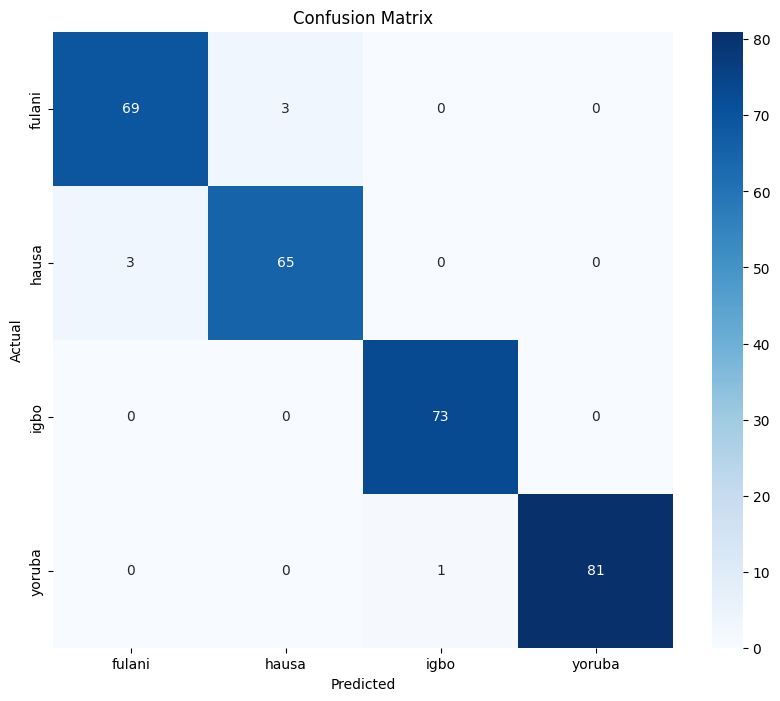

              precision    recall  f1-score   support

      fulani       0.96      0.96      0.96        72
       hausa       0.96      0.96      0.96        68
        igbo       0.99      1.00      0.99        73
      yoruba       1.00      0.99      0.99        82

    accuracy                           0.98       295
   macro avg       0.98      0.98      0.98       295
weighted avg       0.98      0.98      0.98       295



In [8]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))


### Saving the Model

In [25]:
# Saving (more portable way)
torch.save(model.state_dict(), 'efficientnetb0_weights.pth')



### Loadiing the Model

In [26]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch

# Recreate model architecture
model = efficientnet_b0(weights=None)  # no warning
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

# Load the weights
state_dict = torch.load('efficientnetb0_weights.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()


/tmp/ipykernel_6818/1310851247.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('efficientnetb0_weights.pth', map_location='cpu')


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
!python ethnic_classifier_gradio_app.py

/home/naziruai/miniconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/naziruai/miniconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/naziruai/Desktop/arewaDS_workspace/DL-Capstone-Project-Group-9/ethnic_classifier_gradio_app.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untruste

In [22]:
state_dict = torch.load('efficientnetb0_weights.pth', map_location='cpu')
print(state_dict.keys())


odict_keys(['_conv_stem.weight', '_bn0.weight', '_bn0.bias', '_bn0.running_mean', '_bn0.running_var', '_bn0.num_batches_tracked', '_blocks.0._depthwise_conv.weight', '_blocks.0._bn1.weight', '_blocks.0._bn1.bias', '_blocks.0._bn1.running_mean', '_blocks.0._bn1.running_var', '_blocks.0._bn1.num_batches_tracked', '_blocks.0._se_reduce.weight', '_blocks.0._se_reduce.bias', '_blocks.0._se_expand.weight', '_blocks.0._se_expand.bias', '_blocks.0._project_conv.weight', '_blocks.0._bn2.weight', '_blocks.0._bn2.bias', '_blocks.0._bn2.running_mean', '_blocks.0._bn2.running_var', '_blocks.0._bn2.num_batches_tracked', '_blocks.1._expand_conv.weight', '_blocks.1._bn0.weight', '_blocks.1._bn0.bias', '_blocks.1._bn0.running_mean', '_blocks.1._bn0.running_var', '_blocks.1._bn0.num_batches_tracked', '_blocks.1._depthwise_conv.weight', '_blocks.1._bn1.weight', '_blocks.1._bn1.bias', '_blocks.1._bn1.running_mean', '_blocks.1._bn1.running_var', '_blocks.1._bn1.num_batches_tracked', '_blocks.1._se_reduce.w

/tmp/ipykernel_6818/1891171929.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('efficientnetb0_weights.pth', map_location='cpu')
